In [ ]:
import keras
from keras import layers
from keras import models
from keras.callbacks import TensorBoard
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_digits
import time
%matplotlib inline

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d alessiocorrado99/animals10

 98% 575M/586M [00:04<00:00, 119MB/s]
100% 586M/586M [00:04<00:00, 138MB/s]


In [ ]:
! unzip "animals10.zip"

In [ ]:
def normalize_image(image):
    return image/255

def load_image(path, width, height):
    image = Image.open(path).resize((width, height))
    image = np.array(image, dtype=np.float32)
    return normalize_image(image)

def load_images(path, width, height):
    images = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                image = load_image(os.path.join(root, file), width, height)
                if len(image.shape) != 3: continue
                if image.shape[2] != 3: continue
                images.append(image)
    return np.array(images)


In [ ]:
image_width, image_height, num_channels = 128, 128, 3
images = load_images("raw-img", image_width, image_height)

In [ ]:
encoder_inputs = layers.Input(shape=(image_width, image_height, num_channels))
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
conv_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation="relu")(x)
# x = layers.Dense(units=64, activation="relu")(x)
# x = layers.Dense(units=32, activation="relu")(x)
latent_size = 2
mu = layers.Dense(units=latent_size)(x)
sigma = layers.Dense(units=latent_size)(x)

def sample(args):
    mu, sigma = args
    dim = mu.shape[1]
    eps = tf.random.normal((1, dim))
    return mu + tf.exp(0.5*sigma)*eps

z = layers.Lambda(sample)([mu, sigma])
encoder = models.Model(encoder_inputs, [mu, sigma, z], name="encoder")

decoder_inputs = layers.Input(shape=(latent_size,))
x = layers.Dense(units=32, activation="relu")(decoder_inputs)
x = layers.Dense(units=64, activation="relu")(x)
x = layers.Dense(units=128, activation="relu")(x)
x = layers.Dense(units=conv_shape[1]*conv_shape[2]*conv_shape[3], activation="relu")(x)
x = layers.Reshape(conv_shape[1:])(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(num_channels, 3, activation="relu", padding="same")(x)

decoder = models.Model(decoder_inputs, x, name="decoder")


class VAE(models.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mu, sigma, z = self.encoder(data)
            recon = self.decoder(z)
            # reconstruction loss
            recon_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, recon))
            # kl divergence
            kl_loss = -.5*tf.reduce_mean(1 + sigma - tf.square(mu) - tf.exp(sigma))
            total_loss = kl_loss + recon_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.total_loss_tracker.result()
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(images[:500], epochs=500)
# encoder.summary()
# decoder.summary()


Epoch 1/500
16/16 [==============================] - 44s 3s/step - loss: 6.8383
Epoch 2/500
16/16 [==============================] - 41s 3s/step - loss: 1.6041
Epoch 3/500
16/16 [==============================] - 33s 2s/step - loss: 0.7473
Epoch 4/500
16/16 [==============================] - 41s 3s/step - loss: 1.6390
Epoch 5/500
16/16 [==============================] - 35s 2s/step - loss: 0.7535
Epoch 6/500
16/16 [==============================] - 34s 2s/step - loss: 0.7111
Epoch 7/500
16/16 [==============================] - 35s 2s/step - loss: 0.7053
Epoch 8/500
16/16 [==============================] - 35s 2s/step - loss: 0.8986
Epoch 9/500
16/16 [==============================] - 36s 2s/step - loss: 1.2366
Epoch 10/500
16/16 [==============================] - 35s 2s/step - loss: 0.9811
Epoch 11/500
16/16 [==============================] - 34s 2s/step - loss: 0.8517
Epoch 12/500
16/16 [==============================] - 34s 2s/step - loss: 0.8536
Epoch 13/500
16/16 [=================

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 43ms/step


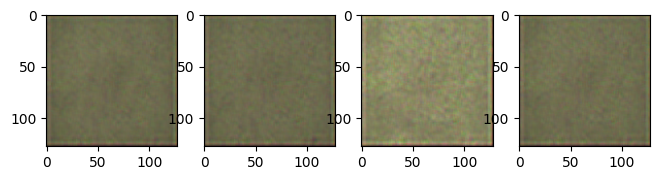

In [ ]:
# p = decoder.predict(images[:1])

fig = plt.figure(figsize=(20, 20))
for i in range(4):
    fig.add_subplot(1, 10, i+1)
    _, _, z = encoder(images[1:2])
    # rv = np.random.normal(loc=z)
    p = decoder.predict(z)
    # p = decoder.predict(rv)
    if num_channels == 1:
        plt.imshow(p[0], cmap="gray")
    else:
        plt.imshow(p[0])


1/1 [==============================] - 0s 241ms/step


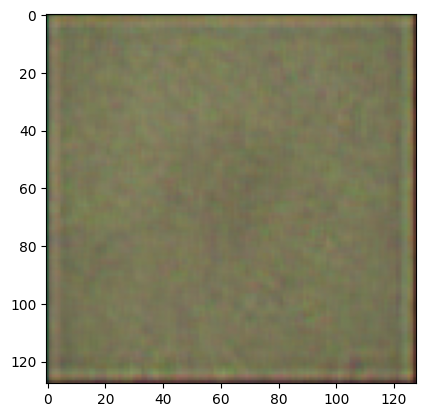

In [ ]:
z = np.array([[1, -.6]])
p = decoder.predict(z)
plt.imshow(p[0])

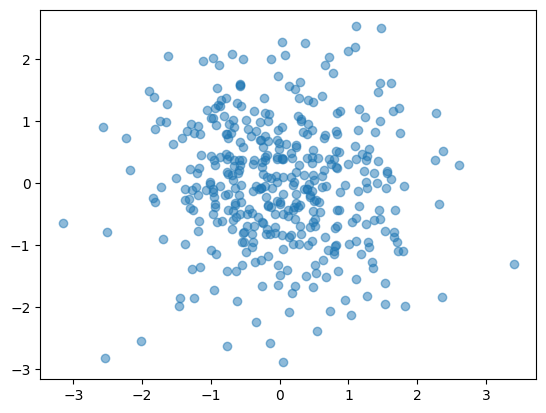

In [ ]:
scatter_x = []
scatter_y = []
for i in range(20):
    for j in range(20):
        _, _, z = encoder(images[j:j+1])
        scatter_x.append(z[0][0])
        scatter_y.append(z[0][1])
plt.scatter(scatter_x, scatter_y, alpha=0.5)